# What's  Cooking Project - Part1
### by Pauline Gerritsen, Shubhada Gopale, Stanislav Ivashkevich, Sumithra Hariguruprasad

# Introduction

###  “Picture yourself strolling through your local, open-air market… What do you see? What do you smell? What will you make for dinner tonight?”

- The objective of this dataset presented in the Kaggle Competition is to predict the category of a dish's cuisine given a list of its ingredients. 

- Some of our strongest geographic and cultural associations are tied to a region’s local foods hence a list of ingredients would be a clue to which cuisine that dish belongs

- The dataset contains 20 international cuisines from **Yummly.** 
- Yummly is a mobile app and website that provides recipe recommendations personalized to the individual's tastes, semantic recipe search, a digital recipe box, shopping list and one-hour grocery delivery
- The train dataset contains 39774 dish-ids along with their ingredients and cuisine label. The test data contains 9944 dish-ids along with their ingredients. **Our task is to predict cuisine for a particular dish from test data given its ingredient set.**

- The data is stored in JSON format. 
    - An example of a recipe node in train.json:
    
            {
             "id": 38714,
             "cuisine": "indian",
             "ingredients": [
             "ice cubes",
             "vanilla extract",
             "honey",
             "ground cardamom",
             "ground cinnamon",
             "1% low-fat milk",
             "nonfat yogurt",
             "mango"
             ]
             }


# Importing Libraries

In [1]:
#Library install commands:
#pip install chart_studio
#pip install plotly==4.1.0
#pip install wordcloud
#pip install nltk

In [2]:
# Data processing 
import pandas as pd
import json
from collections import Counter
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re


# Data vizualizations
import random
#import chart_studio.plotly
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)
import plotly.offline as offline
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from wordcloud import WordCloud, STOPWORDS  


from nltk.stem import WordNetLemmatizer
from itertools import chain

# Load Dataset

In [3]:
train = pd.read_json('train.json') # store as dataframe objects

In [4]:
train.shape

(39774, 3)

In [5]:
train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


The train data provided is in json format. 

We have imported the data as a data frame object  We observe that each recipe is a separate row and has:

- a unique identifier - the 'id' column;
- the type of cuisine in which this recipe falls - this is our target variable (the test sample does not have this column);
- a list object with ingredients (the recipe) - this will be the main source of explanatory variables in our classification problem.

**Problem statement:** Predict the type of cuisine based on given data (ingredients). This is a classification task which requires text processing and analysis.

# Data Exploration

### <u>Lets first explore the target variable - Cuisine</u>
###  Number of Unique Cuisines

In [7]:
print("Number of cuisines: {}".format(len(train.cuisine.unique())))
train.cuisine.unique()

Number of cuisines: 20


array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

There are 20 different cuisines (categories) which we are going to predict. 
This means that the problem at hand is a multi-class classification (there are more than 2 categories to predict). 

### Cuisine Distribution

Text(0.5, 1.0, 'Cuisine Distribution')

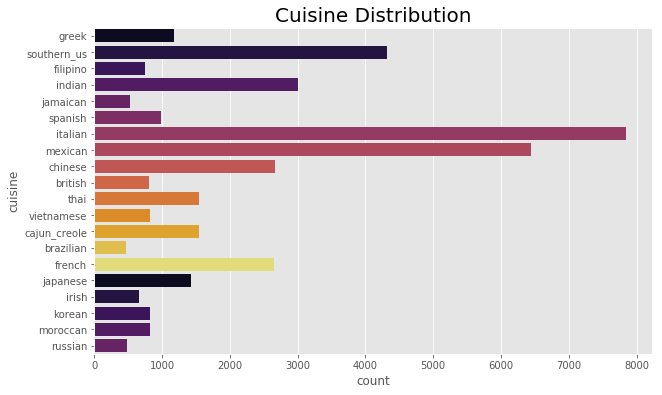

In [8]:
sns.countplot(y='cuisine', data=train,palette=sns.color_palette('inferno',15))
plt.gcf().set_size_inches(10,6)
plt.title('Cuisine Distribution',size=20)

### Let us define a function for generating colours at random - it will be used for vizualization in the analysis

In [9]:
def random_colours(number_of_colors):
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

### Cuisine distributuion in terms of Percentage

In [10]:
#  Label distribution in percents
recipepercent = []
for i in train.cuisine.value_counts():
    percent = (i/sum(train.cuisine.value_counts()))*100  # number of particular cuisine/total number of cuisines
    percent = "%.2f" % percent
    percent = str(percent + '%')
    recipepercent.append(percent)

In [11]:
trace = go.Bar(
            x=train.cuisine.value_counts().values[::-1], 
            y= [i for i in train.cuisine.value_counts().index][::-1],
            text =recipepercent[::-1],  textposition = 'outside', 
            orientation = 'h',marker = dict(color = random_colours(20)))
layout = go.Layout(title='Percentage of recipes in each cuisine category',
                   titlefont = dict(size = 20),
                   width=900, height=400, 
                   plot_bgcolor = 'rgba(0,0,0,0)',# RGBA color values are an extension of RGB color values with an alpha channel 
                                                  # which specifies the opacity for a color.
                   paper_bgcolor = 'rgba(255, 219, 227, 0.88)',
                   margin=dict(l=75,r=80,b=50,t=60),
                   )
data = [trace]
fig = dict(data=data, layout=layout)
iplot(fig, filename='horizontal-bar')

We see that the dataset has almost 20% recipes from Italian cuisine, 16% recipes from Mexican cuisine, 11% recipes from Southern US cuisine. Indian, Chinese and French recipes are almost equal in numbers i.e. 7%.  The rest of the cuisine each have 1-4% recipes in the dataset. So the data is imbalanced i.e. all of the cuisines do not have equal number of recipes.

#### Let us Creating a table giving information on the number of times each cuisine is represented in the training sample

In [12]:
trace = go.Table(
                header=dict(values=['Cuisine','Number of recipes'],
                fill = dict(color=['#EABEB0']), 
                align = ['center'] * 5),
                cells=dict(values=[train.cuisine.value_counts().index,train.cuisine.value_counts()],
               align = ['center'] * 5))

layout = go.Layout(title='Number of Recipes in each Cuisine ',
                   titlefont = dict(size = 20),
                   width=500, height=650, 
                   paper_bgcolor =  'rgba(0,0,0,0)',
                   plot_bgcolor = 'rgba(0,0,0,0)',
                   autosize = False,
                   margin=dict(l=20,r=20,b=1,t=50,pad=2),
                   )
data = [trace]
fig = dict(data=data, layout=layout)
iplot(fig)

 
  #### The presence of Italian cuisine is maximum in train data

### <u> Let us explore the Ingredients in our dataset </u>
### Number of ingredients in each recipe

In [13]:
train_df = train.copy()
train_df['ingredients_text'] = train_df['ingredients'].apply(lambda x: ', '.join(x))
train_df['num_ingredients'] = train_df['ingredients'].apply(lambda x: len(x))
train_df.head()

,cuisine,id,ingredients,ingredients_text,num_ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce, black olives, grape tomatoes,...",9
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour, ground pepper, salt, tomatoes, gr...",11
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs, pepper, salt, mayonaise, cooking oil, gr...",12
3,indian,22213,"[water, vegetable oil, wheat, salt]","water, vegetable oil, wheat, salt",4
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...","black pepper, shallots, cornflour, cayenne pep...",20


### Maximum and Minimum Number of Ingredients

In [14]:
print('Maximum Number of Ingredients in a Recipe: ',train['ingredients'].str.len().max())
print('Minimum Number of Ingredients in a Recipe: ',train['ingredients'].str.len().min())
print('Mean of Ingredients in a Recipe: ',train['ingredients'].str.len().mean())


Maximum Number of Ingredients in a Recipe:  65
Minimum Number of Ingredients in a Recipe:  1
Mean of Ingredients in a Recipe:  10.76771257605471


### Distribution of Recipe length

In [15]:
trace = go.Histogram(
    x= train['ingredients'].str.len(),
    xbins=dict(start=0,end=80,size=1),
   marker=dict(color='MediumPurple'),
    opacity=1)
data = [trace]
layout = go.Layout(
    title='Distribution of Recipe Length',
    xaxis=dict(title='Number of ingredients'),
    yaxis=dict(title='Count of recipes'),
    bargap=0.1,
    bargroupgap=0.2)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

**The distribution of recipe length is right-skewed**. Most of the recipes have between 5-15 ingredients each.

 #### Lets find the number of  recipies which has more than 30 ingredients and less than 10 ingredients

In [16]:
lengthy_recipies = train[train['ingredients'].str.len() > 30]
short_recipes = train[train['ingredients'].str.len() <= 2]
one_ingre = train[train['ingredients'].str.len() == 1]
print("We have {} recipes in the train set which have more than 30 ingredients ".format(len(lengthy_recipies)))
print("We have {} recipes in the train set which have less than or equal to 2 ingredients ".format(len(short_recipes)))
print("We have {} recipes in the train set which have just one ingredient ".format(len(one_ingre)))

We have 40 recipes in the train set which have more than 30 ingredients 
We have 215 recipes in the train set which have less than or equal to 2 ingredients 
We have 22 recipes in the train set which have just one ingredient 


 #### Let's explore the ingredients in the lengthy and the short recipe and also their corresponding cuisine.

In [17]:
print("The ingredients in the longest recipe in our training set which is 65 ingredients." + "\n")
print("They are"+ "\n")
print(str(list(lengthy_recipies[lengthy_recipies['ingredients'].str.len() == 65].ingredients.values)) + "\n")
print("And the corresponding cuisine is: " + str(list(lengthy_recipies[lengthy_recipies['ingredients'].str.len() == 65].cuisine)))

The ingredients in the longest recipe in our training set which is 65 ingredients.

They are

[['fettucine', 'fresh marjoram', 'minced garlic', 'olive oil', 'garlic powder', 'large eggs', 'Alfredo sauce', 'vegetable oil', 'cajun seasoning', 'shredded romano cheese', 'basil dried leaves', 'salt', 'cayenne pepper', 'scallions', 'red bell pepper', 'boneless skinless chicken breast halves', 'soba', 'pasta sauce', 'kosher salt', 'milk', 'fresh ginger', 'ground black pepper', 'flour', 'cooked chicken', 'coarse salt', 'lemon', 'diced tomatoes', 'garlic', 'rice vinegar', 'NeufchÃ¢tel', 'garlic cloves', 'dried parsley', 'frozen artichoke hearts', 'penne', 'pepper', 'sweet onion', 'part-skim mozzarella cheese', 'parmigiano reggiano cheese', 'basil leaves', 'onion powder', 'red wine vinegar', 'red pepper flakes', 'orzo', 'crushed red pepper', 'all-purpose flour', 'freshly ground pepper', 'sliced mushrooms', 'panko breadcrumbs', 'plum tomatoes', 'fresh basil', 'fresh leav spinach', 'water', 'sun-d

In [18]:
print("The ingredients in the shortest recipe in our training set is the recipe with just one ingredient." + "\n")
print("They are"+ "\n")
print(str(list(short_recipes[short_recipes['ingredients'].str.len() == 1].ingredients.values)) + "\n")
print("And the corresponding Cuisines are: " 
      + str(list(short_recipes[short_recipes['ingredients'].str.len() == 1].cuisine)))

The ingredients in the shortest recipe in our training set is the recipe with just one ingredient.

They are

[['sushi rice'], ['dried rice noodles'], ['plain low-fat yogurt'], ['unsalted butter'], ['udon'], ['sticky rice'], ['butter'], ['corn tortillas'], ['grained'], ['lemonade concentrate'], ['jasmine rice'], ['unsalted butter'], ['cherry tomatoes'], ['butter'], ['cumin seed'], ['haricots verts'], ['vegetable oil'], ['spanish chorizo'], ['sweetened condensed milk'], ['water'], ['phyllo'], ['unsalted butter']]

And the corresponding Cuisines are: ['japanese', 'vietnamese', 'indian', 'indian', 'japanese', 'thai', 'indian', 'mexican', 'thai', 'southern_us', 'thai', 'indian', 'italian', 'french', 'indian', 'french', 'mexican', 'spanish', 'spanish', 'japanese', 'greek', 'indian']


### Distribution of recipe length by cuisine

In [19]:
boxplotcolors = random_colours(23)
labels = [i for i in train.cuisine.value_counts().index][::-1]
data = []
for i in range(20):
    trace = go.Box(
    y=train[train['cuisine'] == labels[i]]['ingredients'].str.len(), name = labels[i],
    marker = dict(color = boxplotcolors[i]))
    data.append(trace)
layout = go.Layout(
    title = "Recipe Length Distribution by cuisine"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Box Plot Styling Outliers")

### List of all ingredients used in all recipies

In [20]:
all_ingredients =[]
for recipe in train["ingredients"]:
    for ingre in recipe:
        all_ingredients.append(ingre)
print("The number of ingredients present (including duplicates) in all recipes is :", len(all_ingredients))    

The number of ingredients present (including duplicates) in all recipes is : 428275


### Count of number of times each ingredient occurs

In [21]:
ingre_count = Counter()
for ingre in all_ingredients:
     ingre_count[ingre] += 1


In [22]:
# Most Common ingredients 
print("The top twentyfive most commonly used ingredients are:"+"/n")
print(ingre_count.most_common(25))


# Count of unique ingredients
print("The number of ingredients is",len(ingre_count))


The top twentyfive most commonly used ingredients are:/n
[('salt', 18049), ('onions', 7972), ('olive oil', 7972), ('water', 7457), ('garlic', 7380), ('sugar', 6434), ('garlic cloves', 6237), ('butter', 4848), ('ground black pepper', 4785), ('all-purpose flour', 4632), ('pepper', 4438), ('vegetable oil', 4385), ('eggs', 3388), ('soy sauce', 3296), ('kosher salt', 3113), ('green onions', 3078), ('tomatoes', 3058), ('large eggs', 2948), ('carrots', 2814), ('unsalted butter', 2782), ('ground cumin', 2747), ('extra-virgin olive oil', 2747), ('black pepper', 2627), ('milk', 2263), ('chili powder', 2036)]
The number of ingredients is 6714


### Top 25 most commonly used ingredients

In [23]:
# to visualize top 25 most commonly used ingredients in all the recipes

most_common_ingre = [ingre[0] for ingre in ingre_count.most_common(25)]
most_common_ingre_count = [ingre[1] for ingre in ingre_count.most_common(25)]


In [24]:
trace = go.Bar(
            x=most_common_ingre_count[::-1],
            y= most_common_ingre[::-1],
            orientation = 'h',marker = dict(color = random_colours(28),
))
layout = go.Layout(
    xaxis = dict(title= 'Number of occurences of ingredients in all recipes ', ),
    yaxis = dict(title='Ingredient',),
    title= 'Top 25 Most Commonly Used Ingredients',  titlefont = dict(size = 20),
    margin=dict(l=15,r=10,b=60,t=60,pad=5),
    width=800, height=500, 
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='horizontal-bar')

#### Top 25 most commonly used ingredients in each cuisine

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(tokenizer=lambda x: [i.strip() for i in x.split(',')], lowercase=False)
dummies = vect.fit_transform(train['ingredients'].apply(','.join)) 

df = pd.DataFrame(dummies.todense(),columns=vect.get_feature_names())
print("Vocab Length: ", len(vect.get_feature_names()))
print("All Data Shape: ", df.shape)

Vocab Length:  6724
All Data Shape:  (39774, 6724)


In [26]:
df_train = train
df_train['separated_ingredients'] = df_train['ingredients'].apply(','.join)

In [27]:
# Getting the top 25 ingredients in each cuisine
cuisine_list = train.cuisine.unique()
df_all = {}
for i in cuisine_list:
    counts = vect.fit_transform(df_train[df_train.cuisine == i].separated_ingredients) 
    count=dict(zip(vect.get_feature_names(), counts.sum(axis=0).tolist()[0]))
    count=pd.DataFrame(list(count.items()),columns=['Ingredient','Count'])
    df = count.set_index('Ingredient').sort_values('Count',ascending=False)
    df_all[i] = df.index[0:25]

In [28]:
top_ingr = pd.DataFrame.from_dict(df_all)
top_ingr

,greek,southern_us,filipino,indian,jamaican,spanish,italian,mexican,chinese,british,thai,vietnamese,cajun_creole,brazilian,french,japanese,irish,korean,moroccan,russian
0,salt,salt,salt,salt,salt,salt,salt,salt,soy sauce,salt,fish sauce,fish sauce,salt,salt,salt,soy sauce,salt,soy sauce,salt,salt
1,olive oil,butter,garlic,onions,onions,olive oil,olive oil,onions,sesame oil,all-purpose flour,garlic,sugar,onions,onions,sugar,salt,all-purpose flour,sesame oil,olive oil,sugar
2,dried oregano,all-purpose flour,onions,garam masala,water,garlic cloves,garlic cloves,ground cumin,salt,butter,salt,salt,garlic,olive oil,all-purpose flour,mirin,butter,garlic,ground cumin,onions
3,garlic cloves,sugar,water,water,garlic,extra-virgin olive oil,grated parmesan cheese,garlic,corn starch,milk,coconut milk,garlic,green bell pepper,lime,unsalted butter,sugar,onions,green onions,onions,all-purpose flour
4,feta cheese crumbles,large eggs,soy sauce,ground turmeric,ground allspice,onions,garlic,olive oil,sugar,eggs,vegetable oil,water,butter,water,olive oil,water,sugar,sugar,ground cinnamon,sour cream
5,extra-virgin olive oil,baking powder,pepper,garlic,pepper,water,ground black pepper,chili powder,garlic,unsalted butter,soy sauce,carrots,olive oil,garlic cloves,butter,sake,potatoes,salt,garlic cloves,eggs
6,fresh lemon juice,water,oil,cumin seed,scallions,tomatoes,extra-virgin olive oil,jalapeno chilies,water,sugar,sugar,soy sauce,cayenne pepper,garlic,water,rice vinegar,baking soda,water,water,water
7,ground black pepper,unsalted butter,sugar,ground cumin,dried thyme,ground black pepper,onions,sour cream,green onions,onions,water,shallots,cajun seasoning,cachaca,large eggs,vegetable oil,baking powder,sesame seeds,ground ginger,butter
8,garlic,milk,carrots,vegetable oil,black pepper,red bell pepper,water,avocado,vegetable oil,baking powder,garlic cloves,garlic cloves,all-purpose flour,sugar,garlic cloves,scallions,milk,onions,carrots,unsalted butter
9,pepper,buttermilk,ground black pepper,oil,garlic cloves,pepper,butter,corn tortillas,scallions,large eggs,fresh lime juice,vegetable oil,water,tomatoes,ground black pepper,ginger,carrots,scallions,paprika,large eggs


#### We can see few of the cuisines have lot of unique ingredients to that particular cuisine only. For example
Mexican cuisine - jalapano, avocado, salsa, tortillas   
Indian cuisine - garam masala, turmeric, green chillies    
Greek cuisine - Feta cheese, red wine vinegar, oregano   
Chinese cuisine - soy sauce, oyster sauce, peanut oil, hoisin sauce   
Jamaican cuisine - allspice, thyme, nutmeg   
Cajun-creole cuisine - cajun seasoning, creole seasoning, andouile sausage   
Japanese cuisine - mirin, sake, dashi, nori   
Korean cuisine - soy sauce, sesame oil, Gochujang base, kimchi   
Moroccan cuisine - chick peas, couscous   
Thai, Vietnamese, Filipino cuisine have similar ingredients - fish sauce, soy sauce, vinegar with few different like coconut milk, lemongrass etc   
British, Irish, Russian, Southern_US, French do not have any ingredients only unique to them. So it might be difficult to classify them correctly.

# Visualization using Wordcloud

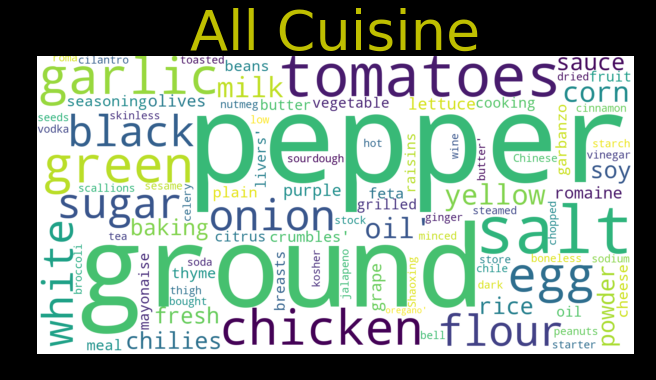

In [29]:

stopwords = set(STOPWORDS)
size = (20,10)

def cloud(text, title, stopwords=stopwords, size=size):  
    """
    Function to plot WordCloud
    Includes: 
    """
    # Setting figure parameters
    plt.rcParams['figure.figsize']=(10.0,10.0)
    plt.rcParams['font.size']=10
    plt.rcParams['savefig.dpi']=100
    plt.rcParams['figure.subplot.bottom']=.1 
    
    # Processing Text
    # Redundant when combined with my Preprocessing function
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='white',
                          stopwords=stopwords,
                         ).generate(str(text))        #  create and generate a word cloud image:
    
    # Output Visualization
    fig = plt.figure(figsize=size, dpi=80,facecolor='k', edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=50,color='y')
    plt.tight_layout(pad=0)
    plt.show()

# Data Set for Word Clouds
train["ing"] = train.ingredients.apply(lambda x: list(map(str, x)), 1).str.join(' ')
# All
cloud(train["ing"].values, title="All Cuisine", size=[8,6])

# Outliers

#### First let us check for the following
1. Number of recipes with just one ingredients
2. Number of ingredients with just 2 characters

### Number of recipe with just one ingredient

In [30]:
print("The number of recipe with just one ingredient ",len(train_df[train_df["num_ingredients"] <= 1]))
train_df[train_df["num_ingredients"] <= 1]

The number of recipe with just one ingredient  22


,cuisine,id,ingredients,ingredients_text,num_ingredients
940,japanese,4734,[sushi rice],sushi rice,1
2088,vietnamese,7833,[dried rice noodles],dried rice noodles,1
6787,indian,36818,[plain low-fat yogurt],plain low-fat yogurt,1
7011,indian,19772,[unsalted butter],unsalted butter,1
8181,japanese,16116,[udon],udon,1
8852,thai,29738,[sticky rice],sticky rice,1
8990,indian,41124,[butter],butter,1
10506,mexican,32631,[corn tortillas],corn tortillas,1
13178,thai,29570,[grained],grained,1
17804,southern_us,29849,[lemonade concentrate],lemonade concentrate,1


### Ingredients with just 2 characters

In [31]:
all_ingredients = [ingredient for ingredients in train.ingredients.values for ingredient in ingredients]
#len(raw_ingredients)
[ingredient for ingredient in  all_ingredients if len(ingredient) <= 2]

['mi', 'mi', 'v8', 'v8']

- From above, it is clear that the recipe with just one ingredient and the ingredient with just two characters do not make sense. So we can consider them as outliers .

### Let us also check  for following 
1. Special Characters
2. Upper Cases
3. Apostrophe
4. Hyphen
5. Numbers
6. Units

### Special Characters

In [32]:
Special_characters=' '.join(sorted([char for char in set(' '.join(all_ingredients)) if re.findall('[^A-Za-z]', char)]))
# re.findall() returns all non-overlapping matches of pattern in string
# [^A-Za-z] matches all strings that contain a non-letter
print("Special Characters are :",Special_characters)

Special Characters are :   ! % & ' ( ) , - . / 0 1 2 3 4 5 6 7 8 9 ¢ § ¨ © ¬ ­ ® º Â Ã â ‚ „ € ™


### Upper Cases

In [33]:
upper_cases=list(set([ingredient for ingredient in all_ingredients if re.findall('[A-Z]+', ingredient)]))
print("There are {} ingredients that start with Uppercase".format(len(upper_cases)))
upper_cases[:10]

There are 499 ingredients that start with Uppercase


['YoplaitÂ® Greek 100 blackberry pie yogurt',
 'Kraft Sun Dried Tomato Vinaigrette',
 'Ragu Traditional Sauce',
 'American cheese',
 'Camellia Red Kidney Beans',
 'Jagermeister Liqueur',
 'Ragu Golden Veggie Fettuccine Pasta',
 'KRAFT Shredded Mozzarella Cheese',
 'Johnsonville Hot & Spicy Breakfast Links',
 'Old El Paso Flour Tortillas']

### Apostrophe

In [34]:
apostrophe = list(set([ingredient for ingredient in all_ingredients if "'" in ingredient]))
print("There are {} ingredients which contain apostrophe".format(len(apostrophe)))
apostrophe

There are 31 ingredients which contain apostrophe


["I Can't Believe It's Not Butter!Â® All Purpose Sticks",
 "Hellmann'sÂ® Real Mayonnaise",
 "M&M's Candy",
 "Quorn Chik''n Tenders",
 "pig's trotters",
 "za'atar",
 "Potatoes O'Brien",
 "soft goat's cheese",
 "Uncle Ben's Original Converted Brand rice",
 "Hellmann's Dijonnaise Creamy Dijon Mustard",
 "Old El Pasoâ„¢ Thick 'n Chunky salsa",
 "devil's food cake mix",
 "Best Food's Mayonnaise with Lime Juice",
 "Campbell's Condensed Tomato Soup",
 "Eggland's BestÂ® eggs",
 "Piment d'Espelette",
 "BREAKSTONE'S Sour Cream",
 "i can't believ it' not butter! made with olive oil spread",
 "Campbell's Condensed Cream of Chicken Soup",
 "Cox's Orange Pippin",
 "hellmann' or best food real mayonnais",
 "Uncle Ben's Ready Rice Whole Grain Brown Rice",
 "Hellmann''s Light Mayonnaise",
 "Campbell's Condensed Cream of Mushroom Soup",
 "Frank'sÂ® RedHotÂ® Original Cayenne Pepper Sauce",
 "tony chachere's seasoning",
 "JOHNSONVILLEÂ® Hot 'N Spicy Brats",
 "Colman's Mustard Powder",
 "Campbell's Condens

### Hyphen

In [35]:
hyphen = list(set([ingredient for ingredient in all_ingredients if re.findall('-', ingredient)]))
print("There are {} ingredients which contain hyphen".format(len(hyphen)))
hyphen[:5]

There are 237 ingredients which contain hyphen


['chicken demi-glace',
 'broiler-fryer chicken',
 'long-grain rice',
 'gluten-free tamari sauce',
 'curly-leaf parsley']

### Numbers

In [36]:
numbers = list(set([ingredient for ingredient in all_ingredients if re.findall('[0-9]', ingredient)]))[:5]
print("There are {} ingredients which contain numbers".format(len(numbers)))
numbers

There are 5 ingredients which contain numbers


['YoplaitÂ® Greek 100 blackberry pie yogurt',
 'licor 43',
 '33% less sodium cooked ham',
 '(14 oz.) sweetened condensed milk',
 '95% lean ground beef']

### Summary of exploratory analysis

The data, which is in json format, has 3 columns {id, cuisine and ingredients}. Cuisine is our target variable and list of ingredients is the source of our explanatory variables. This is a multi-class(20) classification which requires text processing and analysis.

We see that the dataset has almost 20% recipes from Italian cuisine, 16% recipes from Mexican cuisine, 11% recipes from Southern US cuisine. Indian, Chinese and French recipes are almost equal in numbers i.e. 7%.  The rest of the cuisine each have 1-4% recipes in the dataset. So the data is imbalanced i.e. all of the cuisines do not have equal number of recipes.

The range of number of ingredients per recipes is from 1 to 65. Majority of the recipes have between 5-15 ingredients each.

Some of the cuisines like Mexican, Indian, Japanese, Cajun-Creole, Greek, Jamaican have unique ingredients to identify them whereas few cuisines like British, Irish, Russian, French do not have any unique ingredients to differentiate them.

Before we apply modelling, we need to separate each ingredient individually each of which will be a feature into the model. The ingredients have special characters, numbers, units, english conjunctions which we need to remove. We also need to remove words that don't make much sense for example 'aka', 'country', 'serving' etc. Also we need to find a way to combine the various forms of one ingredient i.e. tomato, tomatoes etc.